In [6]:
import numpy as np
import hyperobjects as ho
import matplotlib.pyplot as plt
import opensim as osim

def gravitational_torque(model, state):
    """
    Calculates the gravity torque for each joint in an OpenSim model.
    Since this function does find Tau, st tau = -G -A (in static) with A the applied loads,
    if there are no applied loads then tau = -G ie G = -tau.
    --> The model should have no load applied!!!!.
    """
    # Create InverseDynamicsSolver
    solver = osim.InverseDynamicsSolver(model)    

    # Solve once for all coordinates
    gen_forces = solver.solve(state)
    return -gen_forces.to_numpy()

def station_jacobian(model, state, X, body_X):
    J = osim.Matrix()
    matter: osim.SimbodyMatterSubsystem = model.getMatterSubsystem()
    matter.calcStationJacobian(state, body_X.getMobilizedBodyIndex(), osim.Vec3(X), J)
    return J.to_numpy()

def lever_arm_matrix(state, muscles, coordinates):
    """This is already given as -L.T"""
    N_osim = [[x.computeMomentArm(state, c) for c in coordinates] for x in muscles]
    return np.array(N_osim).T

In [7]:
model = osim.Model()

humerus = osim.Body("humerus",
                    1.0,
                    osim.Vec3(0, 0, 0),
                    osim.Inertia(0, 0, 0))
radius = osim.Body("radius",
                   1.0,
                   osim.Vec3(0, 0, 0),
                   osim.Inertia(0, 0, 0))
hand = osim.Body("hand",
                   1.0,
                   osim.Vec3(0, 0, 0),
                   osim.Inertia(0, 0, 0))

shoulder = osim.GimbalJoint("shoulder",
                         model.getGround(), # PhysicalFrame
                         osim.Vec3(0, 0, 0),
                         osim.Vec3(0, 0, 0),
                         humerus, # PhysicalFrame
                         osim.Vec3(0, 1, 0),
                         osim.Vec3(0, 0, 0))

elbow = osim.GimbalJoint("elbow",
                      humerus, # PhysicalFrame
                      osim.Vec3(0, 0, 0),
                      osim.Vec3(0, 0, 0),
                      radius, # PhysicalFrame
                      osim.Vec3(0, 0.5, 0),
                      osim.Vec3(0, 0, 0))

wrist = osim.GimbalJoint("wrist",
                      radius, # PhysicalFrame
                      osim.Vec3(0, 0, 0),
                      osim.Vec3(0, 0, 0),
                      hand, # PhysicalFrame
                      osim.Vec3(0, 0.2, 0),
                      osim.Vec3(0, 0, 0))

model.addBody(humerus)
model.addBody(radius)
model.addBody(hand)
model.addJoint(shoulder) # Now required in OpenSim4.0
model.addJoint(elbow)
model.addJoint(wrist)

nb_muscles_per_comb = 20
nb_muscles = 4*nb_muscles_per_comb
np.random.seed(42)
for i in range(nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           200.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       model.getGround(),
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        humerus,
                        osim.Vec3(*insertion))
    muscle.setName(f"m_{i}")
    model.addForce(muscle)
    
for i in range(nb_muscles_per_comb,2*nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           200.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       humerus,
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        radius,
                        osim.Vec3(*insertion))
    muscle.setName(f"m_{i}")
    model.addForce(muscle)
    
for i in range(2*nb_muscles_per_comb,3*nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           200.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       radius,
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        hand,
                        osim.Vec3(*insertion))
    muscle.setName(f"m_{i}")
    model.addForce(muscle)

for i in range(3*nb_muscles_per_comb, 4*nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           200.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       humerus,
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        hand,
                        osim.Vec3(*insertion))
    model.addForce(muscle)

model.finalizeConnections()
model.printToXML("arm39_custom.osim")

True

In [8]:
for c in model.getCoordinateSet():
    c: osim.Coordinate = osim.Coordinate.safeDownCast(c)
    print(c.getName())
    # print(c.getRangeMin(), c.getRangeMax())
    # # print(c.get)
    # print(c.getDefaultValue())


shoulder_coord_0
shoulder_coord_1
shoulder_coord_2
elbow_coord_0
elbow_coord_1
elbow_coord_2
wrist_coord_0
wrist_coord_1
wrist_coord_2


In [78]:

model.setGravity(osim.Vec3(0))
state = model.initSystem()

X = [0.00722561, -0.0645789, -0.000513764] # Better adjusted
body_X = model.getBodySet().get("hand")

Qs = np.random.uniform(-np.pi/2, np.pi/2, size=(400, 9))
Qs = np.zeros((400,9))
rad = np.linspace(-180, 180, Qs.shape[0])/180 * np.pi
# rad = np.random.uniform(-np.pi, np.pi, size=(400))
Qs[:,3] = rad

all_K = []
all_N = []
all_Jt_spaces = []
length_muscles = []
active_force = []
passive_force = []


for i, Q in enumerate(Qs):
    for k in range(9):
        model.getCoordinateSet().get(k).setDefaultValue(Q[k])
        model.getCoordinateSet().get(k).setValue(state, Q[k])
        model.getCoordinateSet().get(k).setDefaultSpeedValue(0)
        model.getCoordinateSet().get(k).setSpeedValue(state, 0)

    for muscle in model.getMuscles():
        muscle.setActivation(state, 1)
        muscle.setAppliesForce(state, True)

    model.realizePosition(state)
    model.equilibrateMuscles(state)

    length_muscles_i = []
    active_force_i = []
    passive_force_i = []
    for k, muscle in enumerate(model.getForceSet()):
        muscle: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(muscle)
        
        length = muscle.getLength(state)
        act_force = muscle.getActiveForceLengthMultiplier(state)
        pass_force = muscle.getPassiveForceMultiplier(state)

        length_muscles_i.append(length)
        active_force_i.append(act_force)
        passive_force_i.append(pass_force)

    length_muscles.append(length_muscles_i)
    active_force.append(active_force_i)
    passive_force.append(passive_force_i)
        

    G = gravitational_torque(model, state)
    Jt = station_jacobian(model, state, X, body_X).T
    Jtpinv = np.linalg.pinv(Jt)
    imJt = ho.AffineSpace(Jt)
    N = lever_arm_matrix(state, model.getMuscles(), model.getCoordinateSet())
    all_N.append(N)
    all_Jt_spaces.append(imJt)

    K = ~((ho.AffineMap(N).T)(~imJt))
    all_K.append(K)
    print(i, "done")

length_muscles = np.array(length_muscles)
active_force = np.array(active_force)
passive_force = np.array(passive_force)

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done
101 done
102 done
103 done
104 done
105 done
106 done
107 done
108 done
109 done
110 done
111 done
112 done
113 done
114 done
115 done
116 done
117 done
118 done
119 done
120 done
121 done
122 done
123

In [79]:
import scipy

results = np.zeros((len(all_K), nb_muscles))

all_values_test = []
for i, Q in enumerate(Qs):
    K = all_K[i] # one for each posture
    
    P = (K).orthogonal_projection_matrix
    P_orth = (~K).orthogonal_projection_matrix
    all_values_test_i = []
    # print((~K).dim)
    # print((~K).basis.shape)

    X = np.linspace(0,1,100)
    for k, e in enumerate(np.identity(nb_muscles)):
        p = P@e
        # x = np.linalg.norm(proj)

        # gen = all_N[i][:, k]
        # gen_in_N = N.T @ gen
        # gen_line = ho.Line(gen_in_N)
        # P = gen_line.orthogonal_projection_matrix
        # p = P @ e
        # print(K_gen.dim, K_gen.dim_ambient)
        
        
        # x = all_Jt_spaces[i] << gen
        # x = gen.dot(x) / (np.linalg.norm(x)*np.linalg.norm(gen))
        
        # x = np.linalg.norm(p-e)
        x = np.linalg.norm(p - e)
        print("h", np.linalg.norm(P@e), x)
        # print(np.linalg.norm(p)**2)

        # K_line = ~((ho.AffineMap(all_N[i][:,k]).T)(~all_Jt_spaces[k]))
        # print(K_line.dim)

        # x = (1/np.sqrt(2*np.pi)) * np.exp(-np.linalg.norm(all_N[i][:,k], ord=np.inf)**2/2)
        # x = np.linalg.norm(K_gen.generators, ord=np.inf) / np.linalg.norm(K_gen.generators, ord=2)
        # print(x)
        # print(np.linalg.norm(x)**2 + np.linalg.norm(p)**2, np.linalg.norm(e))
        # t = np.zeros(nb_muscles)
        # t[0] = 1
        # t[1] = 1
        # print(np.linalg.norm(P_orth@t - t))
        # * active_force[i,k]
        # print(active_force[i,k])
        # print(length_muscles[i,k])
        # x = np.linalg.norm(p-e)
        # # / np.linalg.norm(all_N[i], ord=np.inf)
        # print(np.linalg.norm(all_N[i], ord=np.inf), np.linalg.norm(all_N[i], ord=2))
        # # / np.linalg.norm(all_N[i], ord=np.inf)
        # print(np.linalg.norm(all_N[i][:, k], ord=np.inf))

        # Proj_e = ho.Line(e).orthogonal_projection_matrix
        # x = np.arcsin(np.linalg.norm(P_orth @ Proj_e, ord=2))
        # angle_between = np.arccos(proj.dot(e) / np.linalg.norm(proj))
        # all_values_test_i.append(np.linalg.norm(proj - e))
        all_values_test_i.append(x)
    all_values_test.append(all_values_test_i)

all_values_test = np.array(all_values_test)
print(all_values_test.shape)

h 0.998028183138327 0.06276739329946673
h 0.9708416157601522 0.23972183277335724
h 0.9527218323433776 0.3038438911287792
h 0.9916977656406017 0.12859059694797953
h 0.9750137675451339 0.2221444419683807
h 0.8659910450445927 0.5000595063615667
h 0.9810938484676752 0.19353258252523317
h 0.9871007167366991 0.1601005153579949
h 0.8166173121075108 0.5771794916369641
h 0.9644118459653351 0.2644045978452985
h 0.9645395254851813 0.2639384469470522
h 0.9070199646181106 0.42108762007943296
h 0.9793224689494733 0.20230546658631826
h 0.9378915201486507 0.3469286618791433
h 0.9813550852549973 0.1922035292187862
h 0.9885809441061304 0.15069079915586234
h 0.9335786855404355 0.358372484859807
h 0.9576949464402671 0.2877853185323629
h 0.823930435571797 0.5666909539938583
h 0.9810946209992771 0.19352866621326414
h 0.979360805689694 0.2021197968503677
h 0.9754332758427229 0.22029508478115234
h 0.9783662037259293 0.20688057281174
h 0.9211111223374839 0.389299756365427
h 0.9964452125016378 0.084243329009281

In [64]:
passive_force.shape

(400, 80)

Text(0.5, 0, 'Angles')

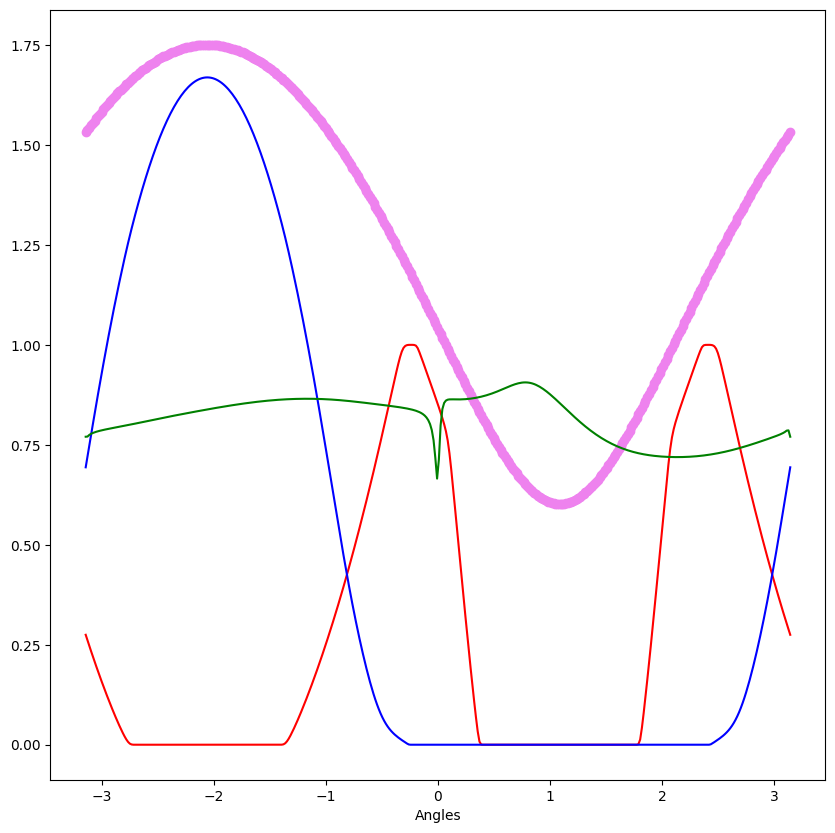

In [89]:
%matplotlib inline
import scipy
import scipy.integrate

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
k = 72
m = model.getMuscles().get(k)
m: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(m)

lengths_of_interest = length_muscles[:, k]
idx_sorted = np.argsort(lengths_of_interest)
idx_sorted = np.argsort(active_force[:,k])
X = active_force[:,k][idx_sorted]
X = rad
# print(rad)

ax.scatter(X, length_muscles[:, k], c="violet")
ax.plot(X, active_force[:, k], c="red")
ax.plot(X, passive_force[:, k], c="blue")
ax.plot(X, 1 - all_values_test[:, k], c="green")

ax.set_xlabel("Angles")
# ax.plot(X, [(np.linalg.norm(l, ord=2)) for l in [all_N[z][:,k] for z in idx_sorted]], c="violet")


# integral = [0.01] + [
#     scipy.integrate.simpson(
#         all_values_test[:, k][idx_sorted[:i]],
#         x=lengths_of_interest[idx_sorted[:i]]
#         ) for i in range(1, len(idx_sorted))]
# # print(integral)
# ax.scatter(lengths_of_interest[idx_sorted], np.exp(integral), c="red")

# ax.set_xlim(0.5,2)
# ax.set_ylim(0,1)

In [298]:
all_N[idx_sorted]

TypeError: only integer scalar arrays can be converted to a scalar index

In [291]:
all_values_test[:, 0][idx_sorted]

array([6.10438852, 6.36337766, 6.2241418 , 6.24482636, 6.19148342,
       5.92221576, 6.29098497, 5.89864173, 6.0931384 , 5.86234647,
       6.30343842, 5.99672823, 6.20243834, 5.88521689, 5.89914122,
       6.10307535, 5.95093332, 6.07140731, 5.78546356, 6.20786493,
       6.43136614, 6.13056235, 6.29676198, 6.2854138 , 6.17632808,
       6.57341067, 6.4418436 , 6.1441207 , 6.08066888, 6.13991571,
       6.00102882, 6.02536101, 6.15089677, 6.38487956, 6.51662238,
       6.05301082, 5.83327521, 6.18046956, 6.1407448 , 6.26281106,
       6.23340253, 6.55063042, 5.88640464, 6.0716389 , 6.51901284,
       5.91487413, 6.4554493 , 6.02086432, 6.03793274, 6.39467116,
       6.24869038, 6.08012291, 6.4292848 , 6.4720553 , 6.26233927,
       6.48770959, 6.50225852, 6.09781363, 6.08610526, 6.14903097,
       5.92848636, 6.12028817, 6.09069541, 6.41421698, 6.25639499,
       6.39716085, 6.29791695, 6.47613619, 6.21046251, 6.39494423,
       6.03169522, 6.17393845, 6.30201765, 6.11775159, 6.60576

In [259]:
1/np.sqrt(2*np.pi)

0.3989422804014327

In [157]:
print(len(integral))
print(lengths_of_interest.shape)

199
(200,)


In [141]:
all_values_test[:, k][idx_sorted].shape
lengths_of_interest[idx_sorted].shape

(200,)

In [82]:
1/all_N[]

0.022222222222222223

In [116]:
all_values_test[:, k][idx_sorted]

array([0.98963001, 0.96640527, 0.98207316, 0.96528405, 0.93879992,
       0.82946883, 0.92542375, 0.97549377, 0.84743415, 0.85036861,
       0.92629492, 0.95372232, 0.89144499, 0.88541215, 0.87714678,
       0.90503393, 0.94398339, 0.8760734 , 0.88957114, 0.79369305,
       0.88960705, 0.85644076, 0.91031363, 0.85547023, 0.82948469,
       0.92360126, 0.82922115, 0.8539742 , 0.87078048, 0.93564246,
       0.88229087, 0.90690852, 0.84486885, 0.89795496, 0.85049027,
       0.78527719, 0.87238969, 0.87502709, 0.98115909, 0.78756271,
       0.78056767, 0.94620066, 0.81414164, 0.84128984, 0.91784777,
       0.82252161, 0.82781063, 0.84689252, 0.86099434, 0.81851239,
       0.91354803, 0.84637534, 0.84742876, 0.7665105 , 0.80632116,
       0.91711744, 0.85580322, 0.86826842, 0.82950394, 0.86920286,
       0.90353922, 0.83000832, 0.88638572, 0.76328547, 0.87502155,
       0.90761512, 0.86397274, 0.92506425, 0.83541918, 0.93680733,
       0.89132104, 0.88225842, 0.89140702, 0.81448093, 0.88414

In [73]:
all_values_test[:, k][idx_sorted]

array([0.93709586, 0.76441405, 0.71470793, 0.64936549, 0.77954052,
       0.44402866, 0.83468534, 0.54735685, 0.57173169, 0.43602756,
       0.47781644, 0.45884488, 0.47159003, 0.74492578, 0.36982844,
       0.46384474, 0.32252232, 0.47404201, 0.54074101, 0.44162119,
       0.38484086, 0.34659141, 0.51678024, 0.50049952, 0.43793509,
       0.62544275, 0.48468867, 0.418757  , 0.56159664, 0.57178953,
       0.56926503, 0.40565343, 0.39562713, 0.39566214, 0.66821886,
       0.60461018, 0.39873617, 0.40716104, 0.48775373, 0.46681633,
       0.41411942, 0.37749268, 0.42771266, 0.61945218, 0.43676336,
       0.37755543, 0.31734621, 0.2712057 , 0.48227794, 0.58905621,
       0.43242111, 0.40436638, 0.41021162, 0.47668354, 0.44927337,
       0.32892269, 0.38655641, 0.49304425, 0.48895528, 0.49159032,
       0.39800548, 0.48097679, 0.34888291, 0.34284246, 0.3855693 ,
       0.4026194 , 0.30210625, 0.50094404, 0.37744147, 0.40620442,
       0.49602549, 0.4358188 , 0.39386825, 0.59854941, 0.39701

In [38]:
lengths_muscles.shape

(300, 30)

In [29]:
Qs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])